# MVP Machine Learning

<a target="_blank" href="https://colab.research.google.com/github/vinicius-souza-lima/mvp_ml/blob/main/mvp_ml.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
from pathlib import Path
import urllib.request
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyarrow as pa
import dask.dataframe as dd
import numpy as np
from PIL import Image

## Problema de Regressão

In [2]:
def load_data(file : str,url : str,**kwargs):
    """
    Função para carregar os dados, verifica se dataset já foi baixado, baixando-o de acordo
    com a necessidade
    """
    file_path = Path(file)
    if not file_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        if url is None:
            raise ValueError("Url não informada")
        urllib.request.urlretrieve(url,file_path)
    return pd.read_csv(file,**kwargs)

## Problema de Classificação (Algoritmos Clássicos)

### Criação do Dataset simplificado a partir das imagens

Objetivo: Classificar imagem de raio x de paciente em saudável, pneumonia bacteriana ou pneumonia virótica

In [ ]:
def load_images(path_dir:str,target_values:list[str],resolution: tuple[int,int]=(128,128)):
    dir = Path(path_dir)
    files = dir.glob("*")
    imgs = []
    targets = []
    for file in files:
        imgs.append(np.array(Image.open(str(file))
                                  .convert("L")  # Converte para escala de cinza
                                  .resize(resolution,Image.Resampling.LANCZOS))) # Redimensiona a imagem 
        targets.append(next((cat for cat in file.name.split("_")
                                  if cat in target_values),"normal")) # procura categoria no nome do arquivo

    return np.stack(imgs),np.array(targets)

In [10]:
imgs_train_normal,y_train_normal = load_images("./datasets/chest_xray/train/NORMAL/")
imgs_train_pneu,y_train_pneu = load_images("./datasets/chest_xray/train/PNEUMONIA/")
imgs_test_normal,y_test_normal = load_images("./datasets/chest_xray/val/NORMAL/")
imgs_test_pneu,y_test_pneu = load_images("./datasets/chest_xray/val/PNEUMONIA/")

In [11]:
np.save("imgs_train_normal.npy",imgs_train_normal)
np.save("y_train_normal.npy",y_train_normal)
np.save("imgs_train_pneu.npy",imgs_train_pneu)
np.save("y_train_pneu.npy",y_train_pneu)
np.save("imgs_test_normal",imgs_test_normal)
np.save("y_test_normal",y_test_normal)
np.save("imgs_test_pneu",imgs_test_pneu)
np.save("y_test_pneu",y_test_pneu)

In [4]:
teste = np.load("imgs_train_pneu.npy")

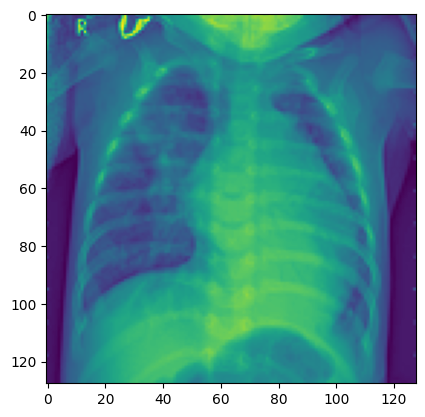

In [45]:
plt.imshow(imgs_train_pneu[10])
plt.show()

## Problema de Visão Computacional (Deep Learning)

Objetivo: Treinar rede neural que classifique os tipos de tumores e segmente na imagem o local em que ele aparece

## Problema de Processamento de Linguagem Natural